In [8]:
import numpy as np
import pandas as pd
import os

In [9]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A 

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [11]:
print(torch.__version__)
print(torchvision.__version__)

2.3.0+cu121
0.18.0+cu121


In [12]:
from pycocotools.coco import COCO

In [13]:
from albumentations.pytorch import ToTensorV2

In [14]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600),
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), 
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [15]:
class AquariumDetection(datasets.VisionDataset):
    def __init__(
        self,
        root,
        split="train",
        transform=None,
        target_transform=None,
        transforms=None,
    ):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]

    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]["file_name"]
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))

    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))

        boxes = [
            t["bbox"] + [t["category_id"]] for t in target
        ] 
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)

        image = transformed["image"]
        boxes = transformed["bboxes"]

        new_boxes = [] 
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.tensor(new_boxes, dtype=torch.float32)

        targ = {}
        targ["boxes"] = boxes
        targ["labels"] = torch.tensor(
            [t["category_id"] for t in target], dtype=torch.int64
        )
        targ["image_id"] = torch.tensor([t["image_id"] for t in target])
        targ["area"] = (boxes[:, 3] - boxes[:, 1]) * (
            boxes[:, 2] - boxes[:, 0]
        )  
        targ["iscrowd"] = torch.tensor(
            [t["iscrowd"] for t in target], dtype=torch.int64
        )
        return image.div(255), targ 

    def __len__(self):
        return len(self.ids)

In [16]:
dataset_path = "../data/Aquarium-Combined"

In [17]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

In [18]:
classes = [i[1]["name"] for i in categories.items()]
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [19]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


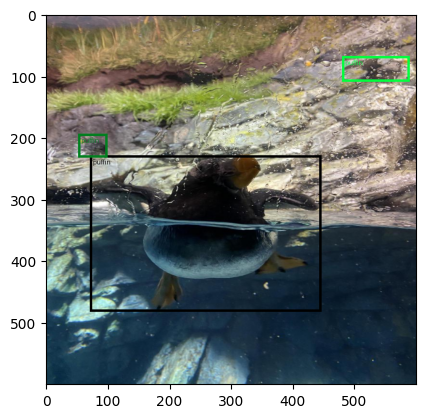

In [20]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(
    draw_bounding_boxes(
        img_int, sample[1]["boxes"], [classes[i] for i in sample[1]["labels"]], width=4
    ).permute(1, 2, 0)
)

In [21]:
len(train_dataset)

447

In [22]:
model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

In [23]:
import torch.nn as nn

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


def create_model(num_classes=7, pretrained=True, coco_model=False):
    model_backbone = torchvision.models.resnet101(weights="DEFAULT")

    conv1 = model_backbone.conv1
    bn1 = model_backbone.bn1
    relu = model_backbone.relu
    max_pool = model_backbone.maxpool
    layer1 = model_backbone.layer1
    layer2 = model_backbone.layer2
    layer3 = model_backbone.layer3
    layer4 = model_backbone.layer4

    backbone = nn.Sequential(conv1, bn1, relu, max_pool, layer1, layer2, layer3, layer4)
    backbone.out_channels = 2048

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
    )
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=["0"], output_size=7, sampling_ratio=2
    )

    model = FasterRCNN(
        backbone=backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
    )

    return model

In [24]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [25]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn)

In [26]:
device = torch.device("cuda")

In [27]:
model = model.to(device)

In [28]:
for images, targets in train_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    output = model(images, targets) 

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4)

In [ ]:
import sys

In [ ]:
def train_one_epoch(model, optimizer, loader, device, epoch):
    model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []

    for images, targets in tqdm(loader):
        images = list(image.to(device) for image in images)
        targets = [
            {k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets
        ]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()

        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping trainig")
            print(loss_dict)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict)  
    print(
        "Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
            epoch,
            optimizer.param_groups[0]["lr"],
            np.mean(all_losses),
            all_losses_dict["loss_classifier"].mean(),
            all_losses_dict["loss_box_reg"].mean(),
            all_losses_dict["loss_rpn_box_reg"].mean(),
            all_losses_dict["loss_objectness"].mean(),
        )
    )

In [ ]:
num_epochs=10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)

100%|██████████| 112/112 [00:19<00:00,  5.83it/s]


Epoch 0, lr: 0.010000, loss: 0.981116, loss_classifier: 0.462532, loss_box: 0.386448, loss_rpn_box: 0.032644, loss_object: 0.099492


100%|██████████| 112/112 [00:18<00:00,  6.05it/s]


Epoch 1, lr: 0.010000, loss: 0.809805, loss_classifier: 0.369262, loss_box: 0.357057, loss_rpn_box: 0.028022, loss_object: 0.055464


100%|██████████| 112/112 [00:18<00:00,  6.01it/s]


Epoch 2, lr: 0.010000, loss: 0.736495, loss_classifier: 0.319393, loss_box: 0.340827, loss_rpn_box: 0.025891, loss_object: 0.050383


100%|██████████| 112/112 [00:18<00:00,  5.98it/s]


Epoch 3, lr: 0.010000, loss: 0.693101, loss_classifier: 0.281855, loss_box: 0.345033, loss_rpn_box: 0.024295, loss_object: 0.041918


100%|██████████| 112/112 [00:17<00:00,  6.37it/s]


Epoch 4, lr: 0.010000, loss: 0.662204, loss_classifier: 0.257868, loss_box: 0.341212, loss_rpn_box: 0.023680, loss_object: 0.039444


100%|██████████| 112/112 [00:18<00:00,  6.06it/s]


Epoch 5, lr: 0.010000, loss: 0.648540, loss_classifier: 0.254600, loss_box: 0.336364, loss_rpn_box: 0.022851, loss_object: 0.034726


100%|██████████| 112/112 [00:17<00:00,  6.34it/s]


Epoch 6, lr: 0.010000, loss: 0.666875, loss_classifier: 0.254783, loss_box: 0.359460, loss_rpn_box: 0.022299, loss_object: 0.030333


100%|██████████| 112/112 [00:17<00:00,  6.38it/s]


Epoch 7, lr: 0.010000, loss: 0.648873, loss_classifier: 0.246731, loss_box: 0.351884, loss_rpn_box: 0.022007, loss_object: 0.028250


100%|██████████| 112/112 [00:17<00:00,  6.29it/s]


Epoch 8, lr: 0.010000, loss: 0.635798, loss_classifier: 0.235610, loss_box: 0.351277, loss_rpn_box: 0.021133, loss_object: 0.027777


100%|██████████| 112/112 [00:17<00:00,  6.22it/s]

Epoch 9, lr: 0.010000, loss: 0.612386, loss_classifier: 0.226363, loss_box: 0.338732, loss_rpn_box: 0.020776, loss_object: 0.026516


In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = AquariumDetection(
    root=dataset_path, split="test", transforms=get_transforms(False)
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
img, _ = test_dataset[5]
img_int = torch.tensor(img * 255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

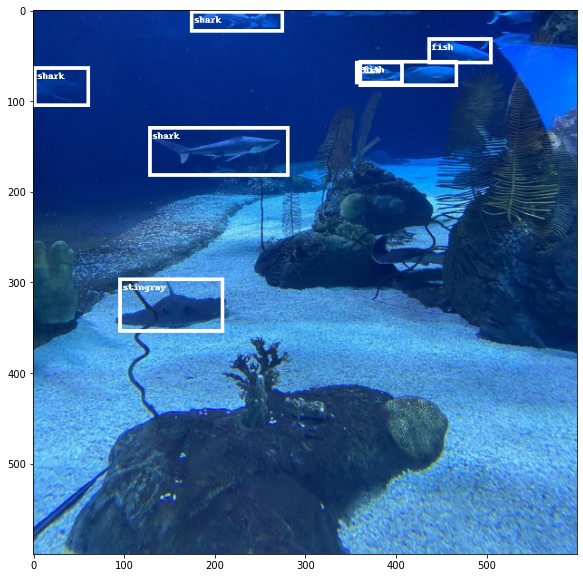

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(
    draw_bounding_boxes(
        img_int,
        pred["boxes"][pred["scores"] > 0.8],
        [classes[i] for i in pred["labels"][pred["scores"] > 0.8].tolist()],
        width=4,
    ).permute(1, 2, 0)
)